# DNN Trading Strategy Simulation

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import time
from datetime import datetime
from datetime import timedelta 
from datetime import timezone
from pybit import usdt_perpetual

from matplotlib import pyplot as plt
from IPython import display

from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from keras.models import Sequential         # Model type
from keras.layers import Dense              # Layers  
from keras.optimizers import Adam, RMSprop  # Optimizers

Using TensorFlow backend.


In [3]:
# Connect to API
client = usdt_perpetual.HTTP(endpoint="https://api-testnet.bybit.com")

In [6]:
# Parameters
symbol = 'ETHUSDT'
start_time =  '2022-07-01 00:00'
end_time = '2022-07-31 00:00'
interval = 15

### Define a function to download data from Bybit

In [7]:
# Define Function:
def get_bybit_data(symbol, interval, start_time, end_time, verbose=False):
    
    ''' Download data from bybit exchange 
    
    Parameters
    ==========
    symbol: string
        asset symbol
    interval: int
        timeframe interval in minutes
    start_time: string
        Starting time of data
    end_time: string
        End point of data
    '''
    
    # Convert time variables to timestamps
    
    # Check that time variables are string
    
    start_time = datetime.strptime(start_time, '%Y-%m-%d %H:%M')
    end_time = datetime.strptime(end_time, '%Y-%m-%d %H:%M')
    
    start_ts = int(start_time.replace(tzinfo=timezone.utc).timestamp())
    end_ts = int(end_time.replace(tzinfo=timezone.utc).timestamp())
    
    # set main list object & current time cursor
    raw_ls = []
    c_ts = start_ts
    
    # while loop to download several pages of data
    while c_ts < end_ts:
        
        # time difference
        diff = int( (end_ts - c_ts) / (interval*60) )    # divide by 60 to get to mins, divide by interval to get to frequency
        
        if verbose:
            print("Downloading data from {}".format(pd.to_datetime(c_ts, unit='s')))
            print("The difference between current time and end time is {}".format(diff))
            print("----------------------------------------------------------------------")
        
        # download data
        temp = client.query_kline(
                symbol=symbol,
                interval=interval,
                limit=min(200,diff),
                from_time=c_ts
        )
        
        # append list to main list
        temp = temp['result']
        raw_ls.extend(temp)
    
        # update time cursor
        c_ts = raw_ls[-1]['start_at'] + interval*60  # interval (m) 
        
        # sleep for a bit
        time.sleep(2)
        
        
    
    # convert to dataframe
    df = pd.DataFrame(raw_ls)
    
    # rename colums
    df.rename(columns = {'symbol':'Symbol',
                           'period':'Period',
                           'interval':'Interval',
                           'start_at':'Start_at',
                           'open_time':'Time',
                           'volume':'Volume',
                           'open':'Open',
                           'high':'High',
                           'low':'Low',
                           'close':'Close',
                           'turnover':'Turnover'
                          }, inplace=True)
    
    # Convert time column to datetime
    df['Start_at'] = pd.to_datetime(df['Start_at'], unit='s')
    df['Time'] = pd.to_datetime(df['Time'], unit='s')

    # Convert fields to numerical values
    df[['Volume','Open','High', 'Close', 'Turnover']] = df[['Volume','Open','High', 'Close', 'Turnover']].apply(pd.to_numeric)    
    
    # Set time column to index
    df.set_index('Time',inplace=True)
    
    # Select columns
    cols = ['Open','High','Low', 'Close','Volume']
    df = df[cols]
    
    # return ohlcv dataframe
    return df

In [8]:
# Download data
raw = get_bybit_data(symbol=symbol,
                    interval=interval,
                    start_time=start_time,
                    end_time=end_time)

In [10]:
data = raw.copy()
data

,Open,High,Low,Close,Volume
Time,,,,,
2022-07-01 00:00:00,1071.25,1072.20,1050.65,1055.15,2362.76
2022-07-01 00:15:00,1055.15,1113.40,1054.85,1092.65,5173.17
2022-07-01 00:30:00,1092.65,1120.00,1088.00,1092.05,8888.63
2022-07-01 00:45:00,1092.05,1105.20,1091.35,1094.50,2779.22
2022-07-01 01:00:00,1094.50,1104.00,1085.90,1086.30,1987.69
...,...,...,...,...,...
2022-07-30 22:45:00,1697.15,1703.00,1691.00,1700.30,335.45
2022-07-30 23:00:00,1700.30,1706.85,1690.50,1692.15,189.71
2022-07-30 23:15:00,1692.15,1697.75,1681.70,1683.55,407.33


### Create Features and Target

In [11]:
## Create Features and target

# Create target
data['return'] = data['Close']/data['Close'].shift(1) - 1
data['direction'] = np.where(data['return'] > 0, 1, 0)

# Create the lagged data
lags = 5

features = []
for lag in range(1, lags + 1):
    feature = f'lag_{lag}'
    data[feature] = data['return'].shift(lag)
    features.append(feature)


# Create additional features
data['momentum'] = data['return'].rolling(5).mean().shift(1)

data['volatility'] = data['return'].rolling(20).std().shift(1)

data['distance'] = (data['Close'] - data['Close'].rolling(50).mean().shift(1)) # consider changing to percentage distance

features.extend(['momentum', 'volatility', 'distance'])

In [12]:
# Sort out columns
cols = features.copy()
cols.append('direction')

In [14]:
# Delete rows containing NAs i.e create dataset
dataset = data[cols].dropna()
dataset

,lag_1,lag_2,lag_3,lag_4,lag_5,momentum,volatility,distance,direction
Time,,,,,,,,,
2022-07-01 12:30:00,0.001715,-0.000524,0.004400,-0.002291,0.006001,0.001860,0.005466,-14.611,1
2022-07-01 12:45:00,0.001427,0.001715,-0.000524,0.004400,-0.002291,0.000946,0.005382,-17.562,0
2022-07-01 13:00:00,-0.002850,0.001427,0.001715,-0.000524,0.004400,0.000834,0.005404,-15.153,1
2022-07-01 13:15:00,0.001477,-0.002850,0.001427,0.001715,-0.000524,0.000249,0.004579,-14.787,0
2022-07-01 13:30:00,-0.000428,0.001477,-0.002850,0.001427,0.001715,0.000268,0.004571,-1.513,1
...,...,...,...,...,...,...,...,...,...
2022-07-30 22:45:00,0.007659,0.003784,-0.007864,-0.008646,0.003530,-0.000307,0.004757,-12.235,1
2022-07-30 23:00:00,0.001856,0.007659,0.003784,-0.007864,-0.008646,-0.000642,0.004727,-20.677,0
2022-07-30 23:15:00,-0.004793,0.001856,0.007659,0.003784,-0.007864,0.000128,0.004811,-29.483,0


### Training and Test Data Split

In [15]:
# Training and Test Data

# Split 75/25
cutoff = int(len(dataset) * 0.75)

# training_data
training_data = dataset[:cutoff].copy()

# test_data
test_data = dataset[cutoff:].copy()

len(training_data) + len(test_data) == len(dataset)

True

In [16]:
# Create Normalization/ Standardization objects/variables
mu, std = training_data.mean(), training_data.std()

In [18]:
# Standardize train and test data

# train
training_data_ = (training_data - mu)/std

# test
test_data_ = (test_data - mu)/std

### Model Specification and Fitting

In [20]:
## Set up model

# Specify the optimizer
optimizer = Adam(learning_rate=0.0001)

# Set seeds
def set_seeds(seed=100):
    #random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(100)
    
set_seeds()

# Specify the model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(len(features),)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
             loss='binary_crossentropy',
             metrics=['accuracy'])

# Fit the model
model.fit(training_data_[features], 
          training_data['direction'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False)

In [21]:
# evaluate the model on train and test data
train_acc = model.evaluate(training_data_[features], training_data['direction'])[1]
test_acc = model.evaluate(test_data_[features], test_data['direction'])[1]

# create print statements: "The accuracy of the model on test data is 0.89"
print("The accuracy of the model on the test data is {}".format(format(test_acc,'.2f')))

708/708 [==============================] - 0s 17us/step
The accuracy of the model on the test data is 0.56


In [26]:
# save the model

# model will be used as if for the next n periods after which it will be updated again, with new data.

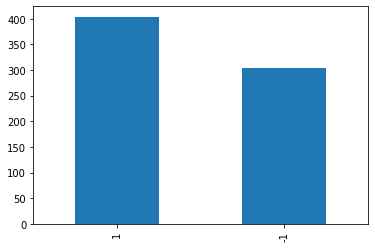

In [25]:
# Backtest Model Performance on out-of-sample data:

# Predictions
pred = np.where(model.predict(test_data_[features]) > 0.5, 1, 0)

test_data['prediction'] = np.where(pred > 0, 1, -1)

test_data['prediction'].value_counts().plot.bar()

In [26]:
# Caculate strategy returns
test = test_data.join(data['return'])
test

,lag_1,lag_2,lag_3,lag_4,lag_5,momentum,volatility,distance,direction,prediction,return
Time,,,,,,,,,,,
2022-07-23 15:00:00,-0.004780,0.002823,-0.005355,-0.001337,0.004225,-0.000885,0.004351,-23.161,1,-1,0.009375
2022-07-23 15:15:00,0.009375,-0.004780,0.002823,-0.005355,-0.001337,0.000145,0.004890,-35.417,0,-1,-0.008473
2022-07-23 15:30:00,-0.008473,0.009375,-0.004780,0.002823,-0.005355,-0.001282,0.005161,-33.786,1,-1,0.000493
2022-07-23 15:45:00,0.000493,-0.008473,0.009375,-0.004780,0.002823,-0.000112,0.004499,-30.698,1,-1,0.001413
2022-07-23 16:00:00,0.001413,0.000493,-0.008473,0.009375,-0.004780,-0.000394,0.004500,-23.749,1,-1,0.003937
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-30 22:45:00,0.007659,0.003784,-0.007864,-0.008646,0.003530,-0.000307,0.004757,-12.235,1,-1,0.001856
2022-07-30 23:00:00,0.001856,0.007659,0.003784,-0.007864,-0.008646,-0.000642,0.004727,-20.677,0,-1,-0.004793
2022-07-30 23:15:00,-0.004793,0.001856,0.007659,0.003784,-0.007864,0.000128,0.004811,-29.483,0,-1,-0.005082


In [27]:
# Calculate strategy returns
test['strategy'] = (test['prediction'] * test['return'])
(1 + test[['return','strategy']]).prod()

return      1.115793
strategy    2.152652
dtype: float64

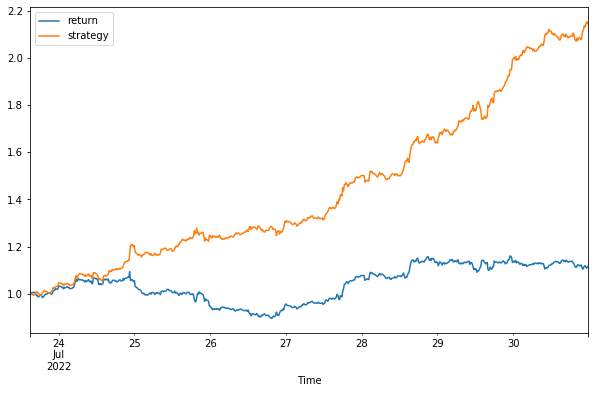

In [29]:
# Plot strategy performance
(1 + test[['return','strategy']]).cumprod().plot(figsize=(10,6))

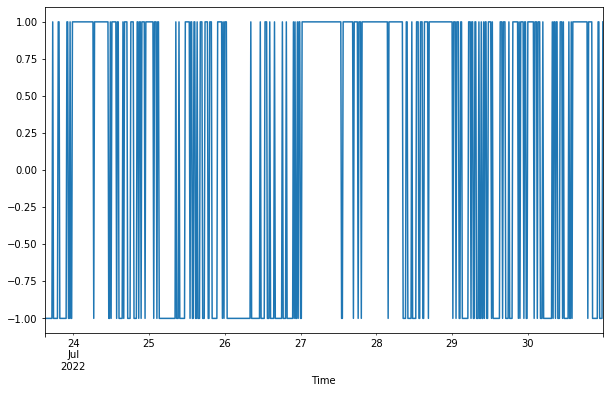

In [31]:
# Plot positions
test['prediction'].plot(figsize=(10,6))

## Live Trading Simulation

In [32]:
# create main_dataset i.e the data that will be updated with new klines
hist_data = data[['Open','High','Low', 'Close','Volume']]
hist_data

,Open,High,Low,Close,Volume
Time,,,,,
2022-07-01 00:00:00,1071.25,1072.20,1050.65,1055.15,2362.76
2022-07-01 00:15:00,1055.15,1113.40,1054.85,1092.65,5173.17
2022-07-01 00:30:00,1092.65,1120.00,1088.00,1092.05,8888.63
2022-07-01 00:45:00,1092.05,1105.20,1091.35,1094.50,2779.22
2022-07-01 01:00:00,1094.50,1104.00,1085.90,1086.30,1987.69
...,...,...,...,...,...
2022-07-30 22:45:00,1697.15,1703.00,1691.00,1700.30,335.45
2022-07-30 23:00:00,1700.30,1706.85,1690.50,1692.15,189.71
2022-07-30 23:15:00,1692.15,1697.75,1681.70,1683.55,407.33


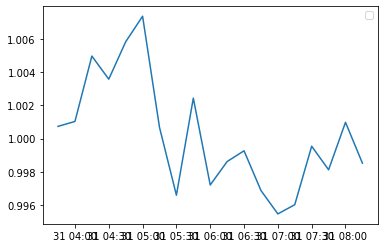

The market is predicted to go Down


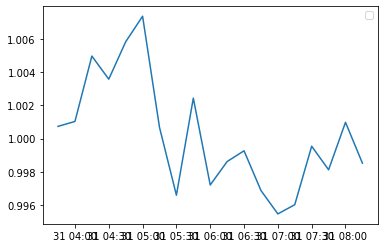

In [36]:
# Simulate Websockt with For loop

results = pd.DataFrame()

for t in range(1,21):
    
    # get latest time and add 1 period
    start_time = hist_data.index[-1] + timedelta(minutes=interval)
    end_time = hist_data.index[-1] + 2 * timedelta(minutes=interval)
    
    # get bar
    bar = get_bybit_data(symbol=symbol,
                        interval=interval,
                        start_time=start_time.strftime('%Y-%m-%d %H:%M'),
                        end_time=end_time.strftime('%Y-%m-%d %H:%M'))
    
    # Print latest bar
    print(bar)
    
    # append to hist_data
    hist_data = hist_data.append(bar) 
    t_data = hist_data.copy()           # create temporary history table
    
    #-----------------------------------------------------------------------------------
    # generate features
    t_data['return'] = t_data['Close']/t_data['Close'].shift(1) - 1
    t_data['direction'] = np.where(t_data['return'] > 0, 1, 0)
    
    # create lag features
    lags = 5
    for lag in range(1, lags + 1):
        feature = f'lag_{lag}'
        t_data[feature] = t_data['return'].shift(lag)
        
    # Create additional features
    t_data['momentum'] = t_data['return'].rolling(5).mean().shift(1)
    t_data['volatility'] = t_data['return'].rolling(20).std().shift(1)
    t_data['distance'] = (t_data['Close'] - t_data['Close'].rolling(50).mean().shift(1))
    
    # Latest observation
    data_point = t_data.iloc[[-1]][cols]
    
    # normalize data
    data_point_ = (data_point - mu) / std
    #--------------------------------------------------------------------------------------
    
    # predict
    pred = np.where(model.predict(data_point_[features]) > 0.5, 1, -1)
    pred = pred.item(0)
    
    bar['prediction'] = pred
    
    # results: Time|Open|High|Low|Close|Volume|prediction
    results = results.append(bar)
    
    # make a copy to plot
    results_ = results.copy()
    results_['return'] = results_['Close']/results_['Close'].shift(1) -1          # calculate returns
    results_['strategy'] = results_['return'] * results_['prediction'].shift(1)   # strategy returns
    results_['cstrategy'] = (1 + results_['strategy']).cumprod()
    
    # Plot:
    plt.gca().cla() 
    plt.plot(results_['cstrategy'])
    plt.legend()
    display.clear_output(wait=True)
    display.display(plt.gcf()) 
    #time.sleep(0.5) 
    
    # print prediction
    print("The market is predicted to go {}".format(np.where(pred == 1, 'Up', 'Down')))
    
    # sleep 30s
    time.sleep(0.5)
    